**Importing the necessary libraries-**

In [1]:
import pickle #in the original code, it was cPickle. Changed it to pickle as cPickle is not supported anymore in latest versions of python
import gzip
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import json
import random
import sys

**Loading the MNIST data-**

In [2]:
def load_data():
    f = gzip.open('/content/drive/MyDrive/neural-networks-and-deep-learning-master - Copy/data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='iso-8859-1') #changed the encoding to iso-8859-1
    f.close()
    return (training_data, validation_data, test_data)  

In [3]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results)) #In python 3.x the object returned by zip() isn't a list, so we added list
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

In [4]:
def vectorized_result(j): 
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [5]:
def TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc):
  ep = []
  for i in range(epochs):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Evaluation loss','Evaluation Accuracy'])

In [6]:
def GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc):
  ep = []
  for i in range(epochs):
    ep.append(i)

  plt.figure(figsize =(10,6))
  plt.plot(eval_cost,label = "Evaluation Loss")
  plt.plot(train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12)
  plt.title("Graph between value of Loss function V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(10,6))
  plt.plot(train_acc,label = "Training Accuracy")
  plt.plot(eval_acc,label = "Evaluation Accuracy")
  plt.ylabel("Accuracy",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12)
  plt.title("Graph between Accuracies V/s Epochs",fontsize = 15)
  plt.show()

In [7]:
class QuadraticCost(object):
    def fn(a, y):
        """Returns the cost associated with an output a and desired output y """
        return 0.5*np.linalg.norm(a-y)**2

    
    def delta(z, a, y):
        """Returns the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

In [8]:
class CrossEntropyCost(object):
    def fn(a, y):
        """Return the cost associated with an output a and desired output y. """
        return np.sum(np.nan_to_num(-y*np.log(a))) #-(1-y)*np.log(1-a)

    def delta(z, a, y):
        """Return the error delta from the output layer.  """
        return (a-y)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining the Neural network-**

In [10]:
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.
        """
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete\n" %j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                #print ("Cost on training data: {}".format(cost))


            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append((accuracy/len(training_data))*100)
                #print ("Accuracy on training data: {} / {}".format(accuracy, n))
                #print("\n")


            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                #print ("Cost on evaluation data: {}".format(cost))


            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy/len(evaluation_data)*100)
                print ("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
                print("_________________________________________________________________\n")

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy


    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        """ Adding the softmax activation at last layer"""
        Numerator = np.exp(zs[-1])
        Denominator = sum(Numerator)
        activations[-1] = Numerator / Denominator


        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.
        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
		
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [12]:
training_data, validation_data, test_data = load_data_wrapper()

1. **Training our Neural Network with 28 neurons in hidden layer, 100 epochs, mini_batch size of 10 and learning rate of 0.01**

In [ ]:
net = Network([784, 28, 10], cost = CrossEntropyCost)
epochs = 100
mini_batch_size = 10
eta = 0.01
lmbda = 0
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 6146 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 7167 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 7587 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 7872 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 8059 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 8213 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 8320 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [ ]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.147775,60.860,0.149036,61.46
1,1,0.091019,70.284,0.090865,71.67
2,2,0.069790,74.920,0.069662,75.87
3,3,0.058086,77.738,0.057978,78.72
4,4,0.049783,79.842,0.049939,80.59
...,...,...,...,...,...
95,95,0.007634,93.828,0.009214,92.53
96,96,0.007554,93.882,0.009151,92.54
97,97,0.007569,93.908,0.009197,92.57
98,98,0.007510,93.878,0.009202,92.54


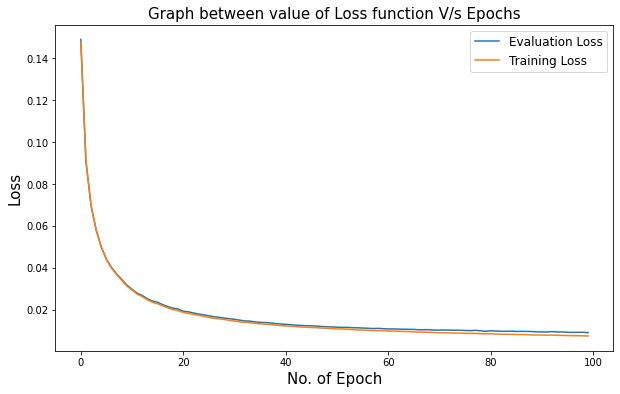



__________________________________________________




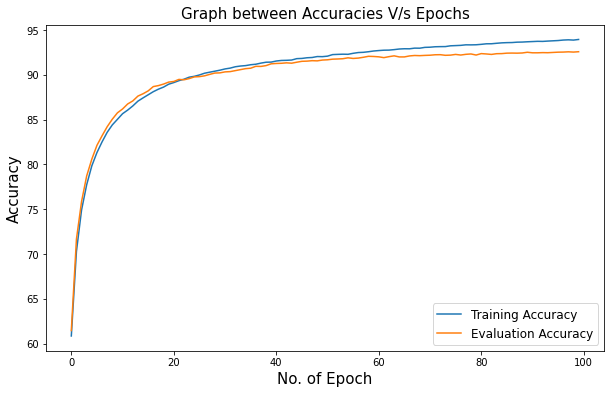

In [ ]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

**Observation-** We see that we are getting decent accuracy at eta value of 0.01 is still increasing, so we increase the learning rate.

In [ ]:
net = Network([784, 28, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 10
eta = 0.1
lmbda = 0
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 8481 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8856 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8934 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9061 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9130 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9169 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9222 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [ ]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

In [ ]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

# **Computing for different values of Eta-**

In [14]:
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True

In [ ]:
net = Network([784, 28, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 10
eta = [0.03,0.05,0.08]
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_1 = []
eval_acc_list_1 = []
train_cost_list_1 = []
train_acc_list_1 = []
for i in range(len(eta)):
  net.large_weight_initializer()
  print("Calculations for the eta value =",eta[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta[i], lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_1.append(eval_cost)
  eval_acc_list_1.append(eval_acc)
  train_cost_list_1.append(train_cost)
  train_acc_list_1.append(train_acc)
  print(dash)

Calculations for the eta value = 0.03 

Epoch 0 training complete

Accuracy on evaluation data: 7752 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8279 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8587 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 8736 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 8835 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 8908 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 8959 / 10000
_________________________________________________________________

Epoch 7 

**Graph between values of Validation Accuracy And Training Accuracy V/s Epochs for different values of Eta**

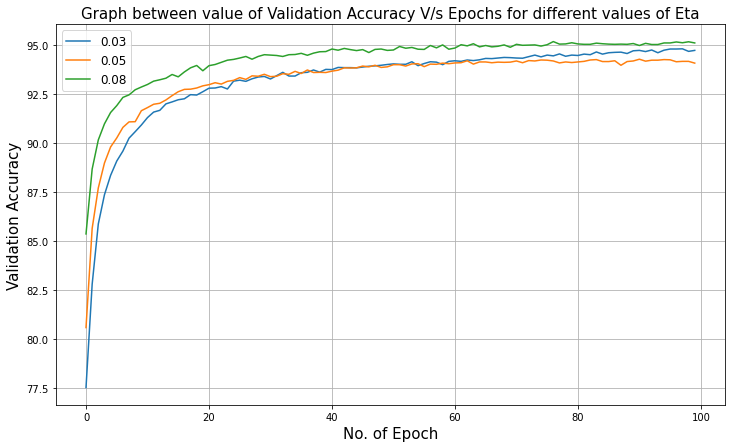



__________________________________________________




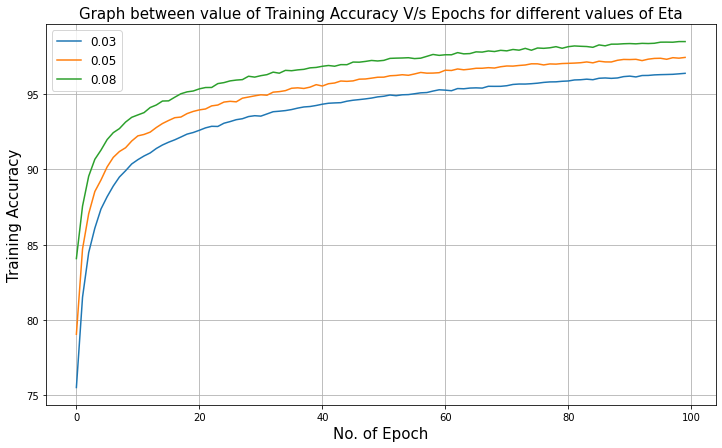

In [ ]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_1)):
    plt.plot(eval_acc_list_1[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_1)):
    plt.plot(train_acc_list_1[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([00.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()

**Graph between values of Validation Loss and Training V/s Epochs for different values of Eta**

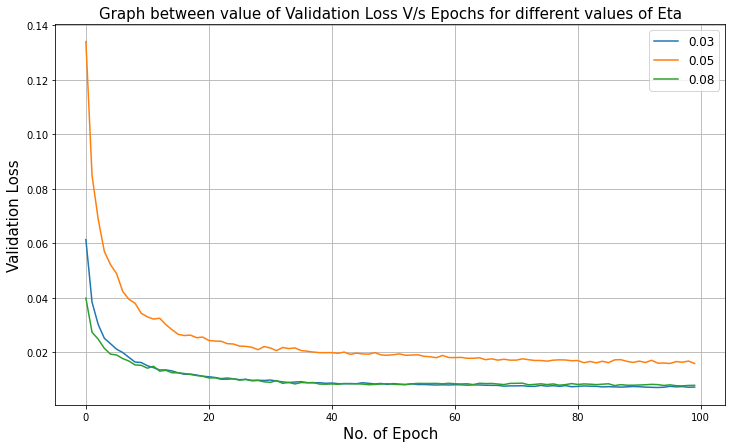



__________________________________________________




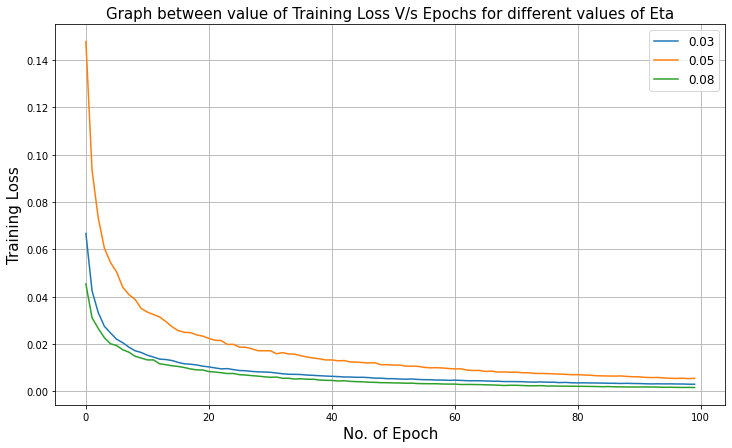

In [ ]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_1)):
    plt.plot(eval_cost_list_1[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_1)):
    plt.plot(train_cost_list_1[i],label = "Training Loss")
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()

In [ ]:
for i in range(len(eta)):
  print("The final validation accuracy for ",eta[i],"Eta value is =",eval_acc_list_1[-len(eta)+i][-1],"\n")

The final validation accuracy for  0.03 Eta value is = 94.73 

The final validation accuracy for  0.05 Eta value is = 94.08 

The final validation accuracy for  0.08 Eta value is = 95.11 



**Observation- Setting the Eta value as 0.05**

# **Computing for different values of mini batch size-**

In [15]:
net = Network([784, 28, 10], cost = CrossEntropyCost)
epochs = 100
mini_batch_size = [1,5,10,50,100,200,50000]
eta = 0.05
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_2 = []
eval_acc_list_2 = []
train_cost_list_2 = []
train_acc_list_2 = []
for i in range(len(mini_batch_size)):
  net.large_weight_initializer()
  print("Calculations for the mini batch size value =",mini_batch_size[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size[i], eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_2.append(eval_cost)
  eval_acc_list_2.append(eval_acc)
  train_cost_list_2.append(train_cost)
  train_acc_list_2.append(train_acc)
  print(dash)

Calculations for the mini batch size value = 1 

Epoch 0 training complete

Accuracy on evaluation data: 9083 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9206 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9298 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9381 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9372 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9370 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9414 / 10000
_________________________________________________________________


**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Mini batch size**

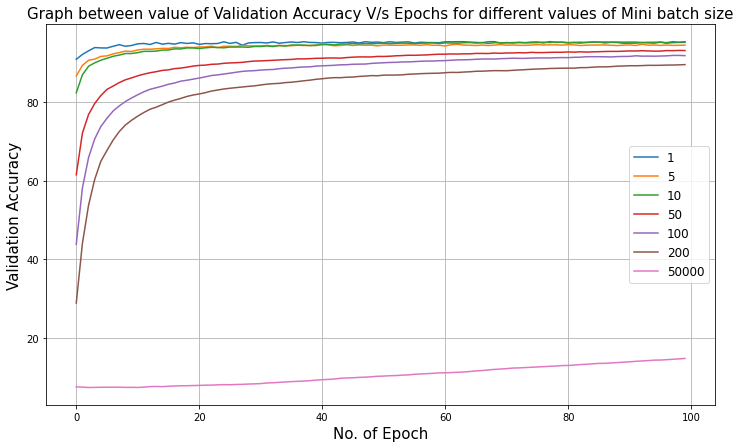



__________________________________________________




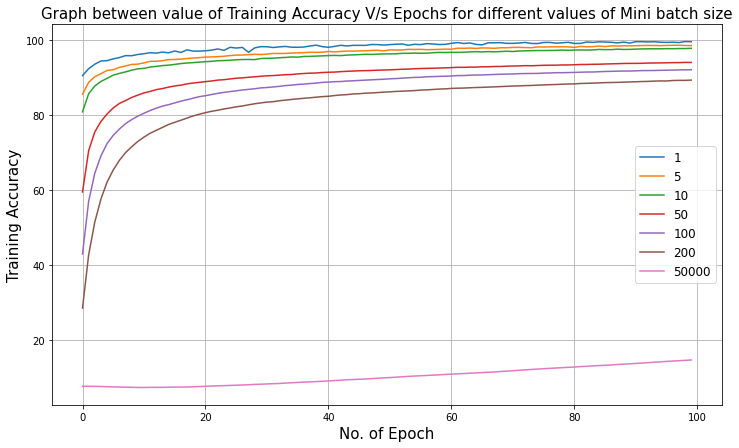

In [16]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_2)):
    plt.plot(eval_acc_list_2[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_2)):
    plt.plot(train_acc_list_2[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Mini batch size**

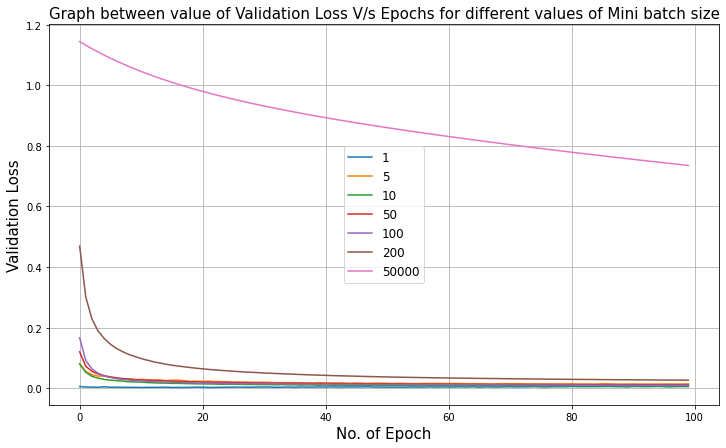



__________________________________________________




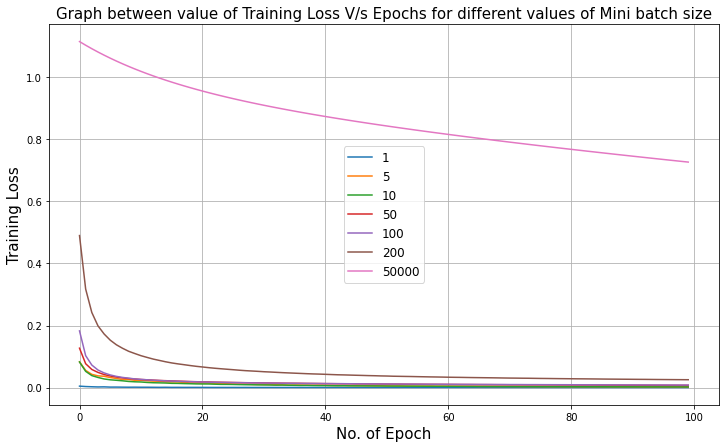

In [17]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_2)):
    plt.plot(eval_cost_list_2[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_2)):
    plt.plot(train_cost_list_2[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

In [18]:
for i in range(len(mini_batch_size)):
  print("The final validation accuracy for ",mini_batch_size[i],"Mini batch size value is =",eval_acc_list_2[-len(mini_batch_size)+i][-1],"\n")

The final validation accuracy for  1 Mini batch size value is = 95.14 

The final validation accuracy for  5 Mini batch size value is = 94.43 

The final validation accuracy for  10 Mini batch size value is = 95.28999999999999 

The final validation accuracy for  50 Mini batch size value is = 93.06 

The final validation accuracy for  100 Mini batch size value is = 91.75999999999999 

The final validation accuracy for  200 Mini batch size value is = 89.48 

The final validation accuracy for  50000 Mini batch size value is = 14.87 



# **Computing for different Epoch values-**

In [19]:
net = Network([784, 28, 10], cost = CrossEntropyCost)
epochs = [20,30,50,100,200]
mini_batch_size = 5
eta = 0.05
lmbda = 0
evaluation_data = validation_data
net.large_weight_initializer()
dash = "_____________________________________________________________"
eval_cost_list_3 = []
eval_acc_list_3 = []
train_cost_list_3 = []
train_acc_list_3 = []
for i in range(len(epochs)):
  net.large_weight_initializer()
  print("Calculations for the epochs size value =",epochs[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs[i], mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_3.append(eval_cost)
  eval_acc_list_3.append(eval_acc)
  train_cost_list_3.append(train_cost)
  train_acc_list_3.append(train_acc)
  print(dash)

Calculations for the epochs size value = 20 

Epoch 0 training complete

Accuracy on evaluation data: 8563 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8855 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8995 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9114 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9140 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9188 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9198 / 10000
_________________________________________________________________

Ep

**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Epochs Size**

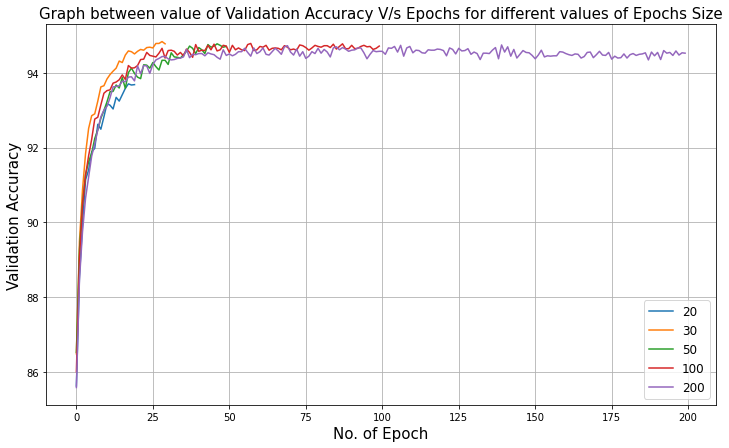



__________________________________________________




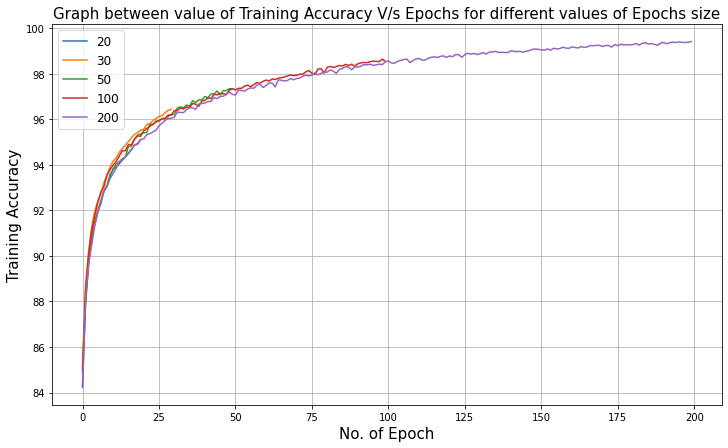

In [20]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_3)):
    plt.plot(eval_acc_list_3[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_3)):
    plt.plot(train_acc_list_3[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Epochs size",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Epochs Size**

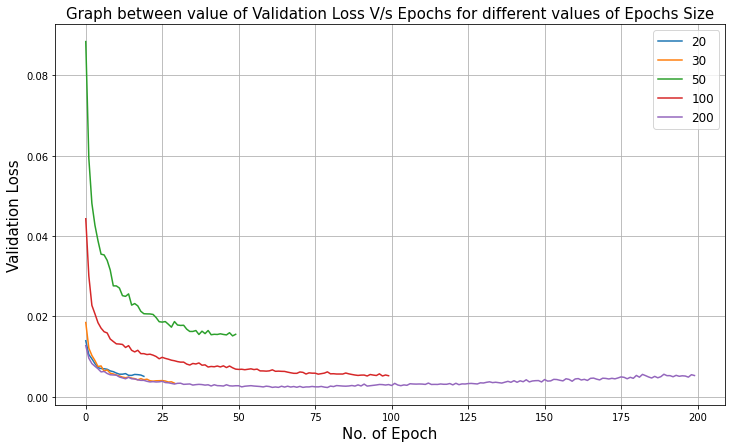



__________________________________________________




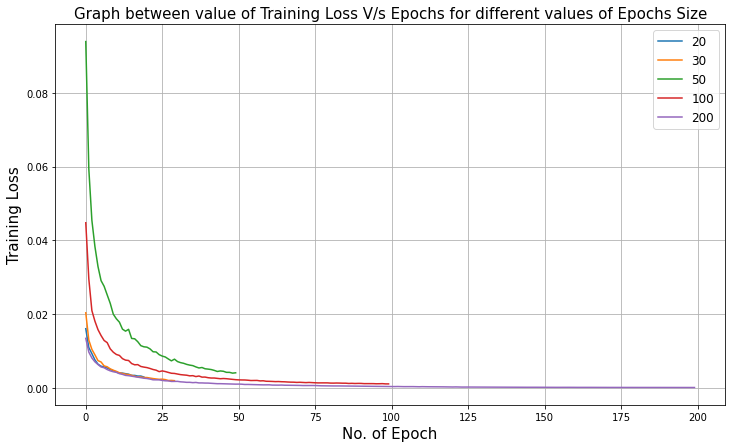

In [21]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_3)):
    plt.plot(eval_cost_list_3[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_3)):
    plt.plot(train_cost_list_3[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()

In [22]:
for i in range(len(epochs)):
  print("The final validation accuracy for ",epochs[i],"Epochs size value is =",eval_acc_list_3[-len(epochs)+i][-1],"\n")

The final validation accuracy for  20 Epochs size value is = 93.67999999999999 

The final validation accuracy for  30 Epochs size value is = 94.77 

The final validation accuracy for  50 Epochs size value is = 94.69999999999999 

The final validation accuracy for  100 Epochs size value is = 94.71000000000001 

The final validation accuracy for  200 Epochs size value is = 94.52000000000001 



**Observation-** Best performance is for epoch size of 100.

# **Now, We increase the hidden layers-**

In [23]:
net = Network([784, 28,15, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 5
eta = 0.05
lmbda = 0
evaluation_data = validation_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 8354 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8795 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8916 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9039 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9134 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9177 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9215 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [24]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.019021,81.694,0.017720,83.54
1,1,0.011439,87.132,0.011648,87.95
2,2,0.008525,88.958,0.009330,89.16
3,3,0.007160,90.400,0.008824,90.39
4,4,0.006204,91.566,0.007852,91.34
...,...,...,...,...,...
95,95,0.000522,98.858,0.010858,94.50
96,96,0.000486,98.912,0.010341,94.46
97,97,0.000472,98.990,0.010443,94.53
98,98,0.000493,98.992,0.010803,94.57


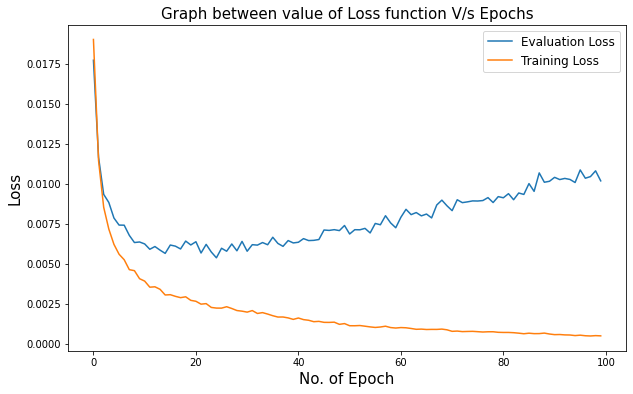



__________________________________________________




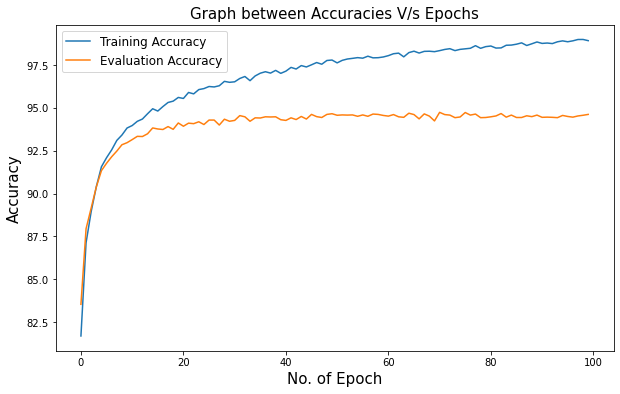

In [25]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)